In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np

import functions.utils as ut
from functions.graph import *

# 0. Preprocess

In [8]:
# Dictionary containing links as keys and categories (multiple) as values
link_cat_dict = ut.link_cat()

# Dictionary containing links as keys and categories (unique-random) as values
unique_link_cat_dict = ut.unique_link_cat(link_cat_dict)

# Dictionary containing categories as keys and links as values
unique_cat_link_dict = ut.unique_cat_link(unique_link_cat_dict)

# Save preprocessed file for future use
ut.write_category_processed(unique_cat_link_dict)

# RQ1
Let's first build the graph, by initializating it and then by manually adding each of the edges to it.

In [9]:
path = 'data/wikigraph_reduced.csv'

graph = Graph()

with open(path) as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        line = line.strip().split()
        line = [int(el) for el in line]
        _, src, dst = line
        graph.add_edge(src, dst)

## Graph info

In [10]:
n_nodes = graph.number_of_nodes()
n_edges = graph.number_of_edges()

if graph.is_directed():
    print('The graph is directed.')
else:
    print('The graph is not directed.')

# Number of articles corresponds to number of nodes src that have an edge src -> dst
print('Number of articles: {}'.format(n_nodes))
# Number of hyperlinks corresponds to number of edges
print('Number of hyperlinks: {}'.format(n_edges))

print('Average number of hyperlinks: {:.1f}'.format(n_edges / n_nodes))
print('Graph density: {:.10f}'.format(graph.density()))

The graph is directed.
Number of articles: 98343
Number of hyperlinks: 483094
Average number of hyperlinks: 4.9
Graph density: 0.0000499516


**Observation about sparsity**:

The density of a graph is a value between 0 and 1. In our case, the density we obtain from our graph is much closer to zero, meaning we can safely assume that the graph is sparse. In fact, we can also observe that there is actually a really small number of hyperlinks for each node.

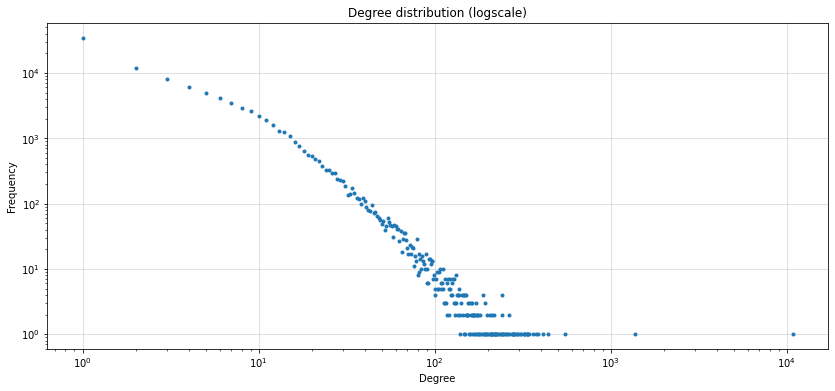

In [13]:
graph.degree_distribution_plot()

# RQ2
Implementation of the function that given in input a page $v$ and a number of clicks $d$, returns the set of pages that a user can reach from $v$ within $d$ clicks.

In [14]:
graph.pages_within_clicks(786432, 2)

{783579,
 785340,
 785517,
 786295,
 786381,
 786382,
 786383,
 786384,
 786385,
 786386,
 786387,
 786388,
 786424,
 786432,
 786433,
 787290,
 787374,
 787377,
 787486,
 787539,
 787552,
 787822,
 999877,
 1000831,
 1622313,
 1622321,
 1622420,
 1622647}

# RQ3

In [71]:
# Example

category = 'English-language_films'

pages = {556939, 601747, 930430, 1041649, 1266258}

graph.min_clicks(category, pages)

5

# RQ4

Before actually applying this function to the subgraph induced by two categories, let's visualize its rationale with an easy example. Let `g` be a directed graph, defined by its edges:


(1 $\to$ 2), 
(1 $\to$ 3), 
(1 $\to$ 6), 
(1 $\to$ 7), 
(2 $\to$ 4), 
(3 $\to$ 4), 
(6 $\to$ 8), 
(7 $\to$ 8), 
(4 $\to$ 5), 
(8 $\to$ 5), 
(1 $\to$ 5)

Let's use `networkxx` to visualize the graph.

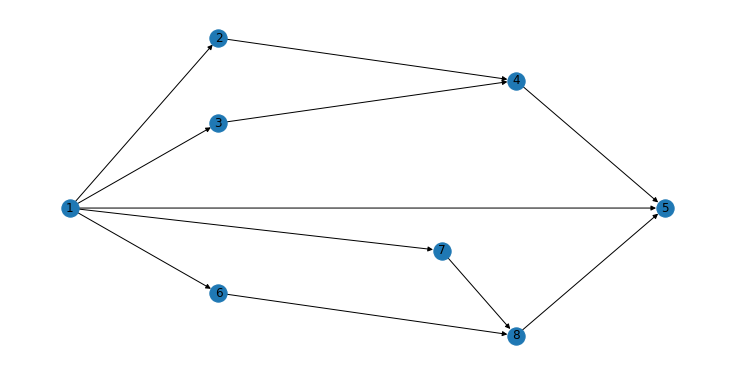

In [11]:
ut.graph_example()

Let's say we want to disconnect nodes **1** and **5**. It should be pretty straightforward that the minimum number of edges we need to remove from the graph in order to disconnect the two nodes are:

(1 $\to$ 5), (4 $\to$ 5), (8 $\to$ 5).

These can be simply obtained by looking at the disjoint paths between 1 and 5, so to actually know the number of edges we need to remove from the graph to disconnect two nodes we just need to see how many disjoint paths connect them.

Now we can create the graph, add the edges and see if this works!

In [72]:
g = Graph()

edges = [
    (1, 2),
    (1, 3),
    (1, 6),
    (1, 7),
    (2, 4),
    (3, 4),
    (6, 8),
    (7, 8),
    (4, 5),
    (8, 5),
    (1, 5),
]

g.add_edges_from(edges)

In [73]:
d = DisjointPaths(g)
d.search(1, 5)
d.paths

[[1, 2, 4, 5], [1, 5], [1, 6, 8, 5]]

In [74]:
print('The minimum set of hyperlinks to remove from the graph to disconnect node 1 and 5 is {}.'.format(min_edge_cut(g, 1, 5)))

The minimum set of hyperlinks to remove from the graph to disconnect node 1 and 5 is 3.


Let's select now two populated categories. The function `categories_size` is going to print in the number of nodes contained in the graph belonging to each category, over a certain threshold (in this case 1000). We are then going to select two categories that, somehow, seem to be related.

Unfortunately, it's not really easy to actually use the function we just created, because the vast majority of subgraphs we can create starting from two categories are going to be poorly connected! It's not that easy to find out two nodes belonging in two different categories with long paths.

In [132]:
categories_sizes = ut.categories_size(graph)

ut.generate_table(categories_sizes, title='Categories Sizes', amount='all')

                               Categories Sizes                               
------------------------------------------------------------------------------
English-language_films                                                 | 13209                                                                 
American_film_actors                                                   | 9063                                                                  
Main_Belt_asteroids                                                    | 8643                                                                  
Rivers_of_Romania                                                      | 7662                                                                  
American_films                                                         | 7639                                                                  
American_television_actors                                             | 6520                                             

In [104]:
category1 = 'The_Football_League_players'
category2 = 'English_footballers'

subgraph = induced_subgraph(graph, category1, category2)

In [108]:
print('The minimum set of hyperlinks to remove from the subgraph to disconnect node 81928 and 82068 is {}.'.format(min_edge_cut(subgraph, 81928, 82068)))

The minimum set of hyperlinks to remove from the subgraph to disconnect node 81928 and 82068 is 1.


# RQ5

In [ ]:
c1 = 'American_television_actors'

ordered_categories = ordered_distances(graph, c1, unique_link_cat_dict)

title = "Category distance from '{}'".format(c1)
ut.generate_table(ordered_categories, title=title, reverse=False)

# RQ6

In [115]:
cat_graph = create_category_graph(graph, unique_link_cat_dict)

In [117]:
PR = pagerank(cat_graph)

In [118]:
ut.generate_table(sort_pr(graph, PR), title='Category PageRank')

                                      Category PageRank                                      
---------------------------------------------------------------------------------------------
English-language_films                                                 | 0.07066980197129522                                                   
Year_of_death_missing                                                  | 0.054435419782986764                                                  
Place_of_birth_missing_(living_people)                                 | 0.054435419782986764                                                  
American_television_actors                                             | 0.054435419782986764                                                  
American_film_actors                                                   | 0.054435419782986764                                                  
Harvard_University_alumni                                              | 0.05220467802595086